# <center>CIFAR10 - Image Classification with Tensorflow & Keras</center>
<br/><center><img src="files/keras-tensorflow-logo.jpg"></center>


## Part-2 - Adding Regularization and Batch Normalization to the Keras model

In this series, we will illustrate multi-class image classification for the CIFAR10 dataset using Convolution Neural Networks (CNNs). The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. Output classes defined are `['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog'. 'horse', 'ship', 'truck']`. You can download the image set for Python from [this link](https://www.cs.toronto.edu/~kriz/cifar.html). However, the Keras library already includes this dataset and I am going to load it from there.  

A good model/network, is one that generalizes well (i.e. performs well on data that it has not seen during training). With CNNs, indeed any deep network, the main problem is overfitting (and hence poor generalization). For a given network/model architecture, we can address overfitting my using regularization & increasing the size of the training data.

We will develop a progressively improving model with the following steps:
1. In [**Part-1**](CIFAR10%20-%20Multiclass%20Classification%20-%20CNN%20-%20Tensorflow%20%26%20Keras-Part-1-Keras.ipynb): We'll develop a base-model. You'll notice that this model overfits and does not generalize well (i.e. accuracy score on test/validation data is poor compared to training data).
2. In **Part-2**: We'll add regularization (- we'll use L2 regularization &amp; dropout regularization) and batch normalization. You'll see that this improves the model's generalization somewhat.
3. In **Part-3**: We'll increase training data size artifically - we'll use image augmentation techniques to create an infinite stream of image batches with random transformations applied to each batch. You'll notice that adding image augmentation improves the model generalization further. We'll use Keras' `ImageDataGenerator()`class [see API](https://keras.io/preprocessing/image/#imagedatagenerator-class) for the same.

Each part has 2 associated IPython notebooks - one with the Keras code and the other with the Tensorflow code. 

**This is Part-2 (Keras Version) - adding regularization &amp; batch normalization** - you can jump directly to the [Tensorflow version here](CIFAR10%20-%20Multiclass%20Classification%20-%20CNN%20-%20Tensorflow%20%26%20Keras-Part-2-Tensorflow.ipynb) if you prefer to use Tensorflow instead.

This workbook is divided into the following sections:
+ [Helper functions](#helper_functions)
+ [Loading & Preprocessing Data](#loading_and_preprocessing)
+ [What is regularization & batch normalization](#whats_dropout_regularization)
+ [Building &amp; running the model with L2 &amp; Dropout Regularization + Batch Normalization](#building_and_running_model)
+ [Predictions](#predictions)

<font color='scarlet'> I would encourage you to run these models on a machine with a GPU - I have run these on a _modest_ configuration (i5 CPU, Win10-64bit, 8GB RAM, 2GB Nvidea GPU). I have also run these on a CPU-only machine, but the models took veeee.....rrrry long to complete.</font>

In [1]:
# imports & tweaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (8,6)
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_style({'font.sans-serif':['Arial','Verdana','Calibri','DejaVu Sans']})
%matplotlib inline

seed = 123
np.random.seed(seed)

## Helper Functions: <a name="helper_functions"/>

In [2]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [3]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

## Loading & Preprocessing Data <a name="loading_and_preprocessing" />

This section is _exactly_ the same as in Part-1, so I am going to provide a very brief explanation. For a more detailed explanation of the loading & preprocessing logic, please refer to [Part-1 Notebook](CIFAR10%20-%20Multiclass%20Classification%20-%20CNN%20-%20Tensorflow%20%26%20Keras-Part-1-Keras.ipynb). 
* We load the data using the `keras.datasets.cifar10.load_data()` function - it loads the images & labels with the correct shapes, so no _re-shaping_ needed.
* Next we apply the following pre-processing steps:
    * We _mean-normalize_ the train & test images (i.e. convert them to _z-scores_ by subtracting the mean of _train_ images along 4 axes and dividing by the standard deviation of the _train_ images along 4 axes
    * We _one-hot-encode_ the labels, since we have 10 output classes.
    * Next, we split the _training_ dataset (images & labels) into a _training_ and _validation_ dataset, with 10% of the original training-set set aside as the validation dataset. We use cross-validation during the training process.

In [4]:
from keras.datasets.cifar10 import load_data
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
(train_data, train_labels), (test_data, test_labels) = load_data()
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [6]:
# need to look at labels again
cifar10_labels = {
    0 : 'Airplane', 
    1 : 'Automobile', 
    2 : 'Bird', 
    3 : 'Cat', 
    4 : 'Deer', 
    5 : 'Dog', 
    6 : 'Frog', 
    7 : 'Horse', 
    8 : 'Ship', 
    9 : 'Truck'    
}

View a random sample of 20 images from the training images set.

In [7]:
rand_20 = np.random.randint(0, train_data.shape[0],20)
sample_data = train_data[rand_20]
sample_labels = train_labels[rand_20].ravel()

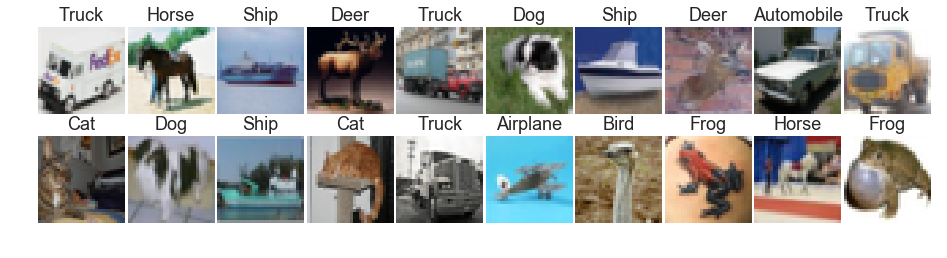

In [8]:
row_count, col_count = 2, 10
f, ax = plt.subplots(row_count, col_count, figsize=(16,4), gridspec_kw={'wspace':0.03, 'hspace':0.01}, squeeze=True)
for r in range(row_count):
    for c in range(col_count):
        image_index = r * col_count + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_data[image_index])
        ax[r,c].set_title(cifar10_labels[sample_labels[image_index]])
plt.show()
plt.close()

In [9]:
# some globals for later use
image_height, image_width = train_data.shape[1], train_data.shape[2]
num_channels = 3 # as we have color images
num_classes = 10  # 10 output classes
input_shape = image_height * image_width * num_channels
image_height, image_width, num_channels, num_classes, input_shape

(32, 32, 3, 10, 3072)

Mean normalize our image data & one-hot encode the labels.

In [10]:
# # normalize the images - between 0.0 & 1.0
# train_data = train_data.astype('float32') / 255.
# test_data = test_data.astype('float32') / 255.

# mean normalize the data (i.e. z-scores)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# mean normalize the images by calculating the mean & stdev of the test images
# along all 4 axes and then finding the z-scores for train & test images using 
# these values.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data,axis=(0,1,2,3))
train_data = (train_data-mean)/(std)
test_data = (test_data-mean)/(std)

In [11]:
# one-hot-encode the labels - so 3 becomes [0 0 0 1 0 0 0 0 0 0] & so on...
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape

((50000, 10), (10000, 10))

In [12]:
train_data.shape, train_labels_cat.shape, test_data.shape, test_labels_cat.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

Split the training data into _training_ and _validation_ sets - we will set aside 10% of training data as the validation set, which we will use to cross-validate during the training process. The _test_ dataset is **not used** during the trainig process at all.

In [13]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

train_data2.shape, train_labels_cat2.shape, val_data.shape, val_labels_cat.shape, test_data.shape, test_labels.shape

((45000, 32, 32, 3),
 (45000, 10),
 (5000, 32, 32, 3),
 (5000, 10),
 (10000, 32, 32, 3),
 (10000, 1))

In [14]:
# some more globals...
num_features = train_data.shape[1]
num_epochs = 15
batch_size = 100

## What is Regularization and Batch Normalization? <a name="whats_dropout_regularization" />

### About Weight Regularization
A common way to mitigate overfitting is to put constraints on the complexity of the network by forcing weights to take on only small values. This can be done by a process called _weight regularization_ which involves adding penalties for larger weight variations (i.e. larger weights are penalized more) to the _loss_ function. There are two flavors of weight regularization:
* _L1 Regularization_: where the penalty added is proportional to the _absolute value_ of the weight coefficients (also called L1 norm)
* _L2 Regularization_: where the penalty added is propostional to the _square value_ of the weight coefficients (also called L2 norm). 

#### Adding Weight Regularization to Keras model
* Keras provides `l1()` and `l2()` classes in the `keras.regularizers` package. Instances of these classes take a parameter which controls the mount of regularization applied.
* Set the value of the `kernel_regularizer` parameter to `regularizers.l1(p)` or `regularizers.l2(p)` to apply L1/L2 regularization respectively to any layer. Value of `p` will determine the amount of regularization applied. We will use `p=0.01` in our model.
* We will apply L2 regularization to our `Conv2D(...)` layers.

### About Dropout Regularization
Dropout is a widely used regularization technique for neural networks. Deep Neural Networks are very prone to overfitting as a typical architecture will have many layers, each with several nodes. So they quickly learn intricate patterns of the training data & hence overfit. It's very rare to find a DNN not overfitting training data!

Dropout is a regularization technique where, during each iteration of gradient descent, a random number of nodes (neurons) are dropped from a layer - dropout is typically applied to dense layers only. So each each iteration, the downstream neurons are presented a different architecture from the previous iteration.  So a neuron cannot rely on any individual neuron's output (since it may be dropped in the next iteration). This reduces co-dependency amongst neurons, effectively reducing overfitting. 

<center> <img src="files/dropout.jpg"> </center>

* We define a _dropout rate_ (r -> (0.0,1.0]) which determines percentage of nodes dropped from a layer (e.g. r = 0.30 means 30% of the nodes are randomly dropped). Alternatively, you may also hear the term _keep probability_, which is essentially the reverse of dropout rate. So if p = 0.70, you are _keeping_ 70% of the nodes.
* You could use the same, or different, dropout rates (or keep-probabilities) for any layer. In the simple case, just use the same percentage for all layers - there is no rule to define which approach is better. You should experiment on your specific network architecture to get the best performance (generalization).
* What value do we choose for r (or p)? Again, there is no rule that defines the best value. You need to experiment with different values & choose the one that performs best (remember: performs well means generalizes well!) Emperically, it is advised that you start with 50% (r = 0.5) reduce it down to 10% (so values between 0.5 and 0.1 are known to work best). 
* **One important point to remember is that dropout is applied _only during training_** - we do not apply dropout during cross-validation or testing!

#### Adding Dropout Regularization to Keras model
This couldn't be simpler in Keras
* Add a new `keras.layers.Dropout(rate=XX)` layer after any layer to which you want to add dropout regularization. This could be a just about any type of layer like `Conv2D()`, `MaxPooling2D()`, `Flatten()` or a `Dense()` layer.
    * `rate=XX` defines the percentage of nodes of the previous layer that should be randomly be dropped _during training_. 
    * Keras handles the _droput during training_ automatically for us, we don't have to do any further checkes that we are running a training loop as opposed to validaton or prediction etc.
    * XX typically takes a value between 0.1 & 0.5 (both inclusive - i.e. from 10% - 50% nodes can be dropped out)
* We will add `Dropout()` after each CNN layer in our model. I experimented with several values, and settled with 0.2, 0.3 and 0.4 for the first, sencond and third pairs of `Conv2D()` layers.

### About Batch Normalization
We know that Neural networks (in fact all machine learning models) perform well when the input data is normalized before feeding it into the algorithm. We use technques like mean normalization, min-max normalization etc. to normalize the input data to the classifier. Batch normlization helps the hidden layers benifit in the same way as the input layers by reducing the amount by which the activations (or hidden layer outputs) shift around (also called co-variance shift).
 
* For a really lucid explanation of how and why this works, please see [Firdaouss Doukkali's Article](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c) on Towards Data Science.
* Professor Andrew Ng explains how and why batch normalization works - see video [here](https://www.youtube.com/watch?v=nUUqwaxLnWs) 
* Also see the [white paper](https://arxiv.org/pdf/1502.03167v3.pdf) by Sergey Ioffe and Christian Szegedy, who has proposed this technique.

#### Adding Batch Normalization to Keras model
* Batch normalization is usually added after a `Conv2D()` layer, but _before applying the activation_ function.
* This can be done easily in Keras by separating out the activation into a separate layer, using `keras.Activation` import. Following 3 steps are required:
    * Remove the the `activation="XXX"` parameter from the `model.add(Conv2D(...))` call(s) 
    * Add a `model.add(BatchNormalization())` layer immediately after the `model.add(Conv2D(...))` calls - use all default parameters (see [API definition](https://keras.io/layers/normalization/))
    * Follow that with your `model.add(Activation("XXX")` call to apply `XXX` activation (where `XXX = "relu" or "elu"` or any activation function that works best) - we will use `elu` as before.

## Building the model with L2 &amp; Dropout Regularization + Batch Normalization <a name="building_and_running_model" />
In the next few cells we will build out our Keras model using the above techniques. The new Keras model architecture is built in the `build_keras_model()` function.

In [15]:
from keras.models import Sequential
from keras import regularizers, optimizers
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, Activation, BatchNormalization

In [16]:
def build_keras_model():
    model = Sequential()
  # CNN layers  
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', 
                     kernel_regularizer=regularizers.l2(0.01),
                     input_shape=(image_height, image_width, num_channels)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))        
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))        
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))     
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))        
    model.add(MaxPooling2D(pool_size=2))       
    model.add(Dropout(0.3))                

    model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))     
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', 
                     kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))                    
    model.add(MaxPooling2D(pool_size=2))                
    model.add(Dropout(0.4))       

  # Flatten
    model.add(Flatten())
  #  model.add(Dropout(0.5))
  # Dense (fully connected) layers
    model.add(Dense(512, activation='relu')) 
  # output layer with softmax
    model.add(Dense(10, activation='softmax'))
  # compile with categorical_crossentropy loss function & adam optimizer
    # NOTE: learning rate will be changed as we train across epochs
    rmsprop = optimizers.RMSprop(lr=0.001,decay=1e-6) # learning rate decays slowly...
    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
kr_model = build_keras_model()
print(kr_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [18]:
# train the model

start_time = time.time()

# from keras.callbacks import LearningRateScheduler

# def lr_scheduler(epoch):
#     if epoch < 10:
#         lrate = 0.001
#     elif epoch < 20:
#         lrate = 0.0005
#     elif epoch < 30:
#         lrate = 0.00025
#     return lrate

# as the model architecture is more complex than in Part-1, we run it through 30 epochs instead of 15
kr_history = kr_model.fit(train_data2, train_labels_cat2, epochs=30, batch_size=100,
                          validation_data=(val_data,val_labels_cat)) #,callbacks=[LearningRateScheduler(lr_scheduler)])

end_time = time.time()
print_time_taken(start_time, end_time)

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 107s 2ms/step - loss: 2.8644 - acc: 0.4339 - val_loss: 1.5880 - val_acc: 0.5556
Epoch 2/30
45000/45000 [==============================] - 108s 2ms/step - loss: 1.4723 - acc: 0.5904 - val_loss: 1.4491 - val_acc: 0.6012
Epoch 3/30
45000/45000 [==============================] - 104s 2ms/step - loss: 1.3293 - acc: 0.6361 - val_loss: 1.2242 - val_acc: 0.6718
Epoch 4/30
45000/45000 [==============================] - 103s 2ms/step - loss: 1.2687 - acc: 0.6600 - val_loss: 1.2462 - val_acc: 0.6602
Epoch 5/30
45000/45000 [==============================] - 103s 2ms/step - loss: 1.2303 - acc: 0.6752 - val_loss: 1.2309 - val_acc: 0.6852
Epoch 6/30
45000/45000 [==============================] - 104s 2ms/step - loss: 1.1962 - acc: 0.6918 - val_loss: 1.2769 - val_acc: 0.6656
Epoch 7/30
45000/45000 [==============================] - 104s 2ms/step - loss: 1.1663 - acc: 0.7034 - val_loss: 1.2693 - v

**Observation & Interpretation:** 
* Notice that after applying dropout regularization and batch normalization,the training accuracy has come down to ~83% (from ~90%). However, the validation accuracy has improved to ~78% (from 73% levels) (see `acc` and `val_acc` columns in the output above). 
* This is still an overfitting model, but the overfitting has reduced substantially.

Let's plot the test & validation losses vs epochs and test & validation accuracies vs epochs. We'll use the `show_plots()` function coded above, which plots out neat graphs in a 1 x 2 grid.. You need to pass the `history` attribute of the return value from the Keras call (see call below).

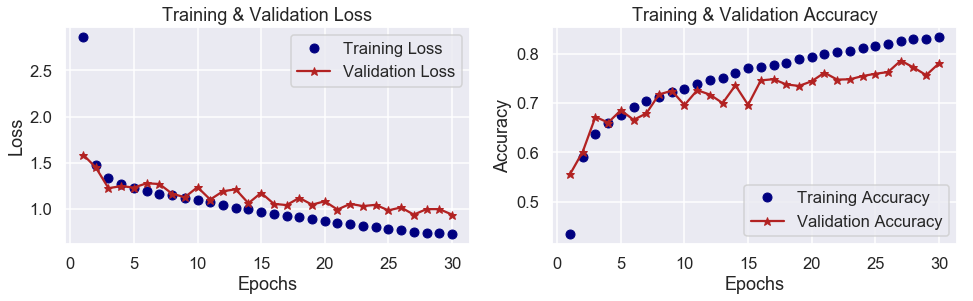

In [19]:
show_plots(kr_history.history) 

**Observations from graphs:** 
+ On the top-left we are plotting training & validation loss vs epochs - we can see that the training loss falls smoothly towards zero. Notice that, unlike in Part-1, the validation loss is closely following the training loss, with a few inytermittant spikes. 
+ On the top-right we are plotting the training & validation accuracies vs epochs - we can see that the training accuracy rises across epochs and approachs 1. The validation loss appears to closely follow the training curve but is more jagged - this is due to the dropout regularization that has been applied.
+ This means that adding regularization has improved the model - the model is generalizing better than before. We still have the problem of lack of training images, so the improvement will not be substantial.

**Next, and very important, let us see how our model performs against test data** - recall that the model has not seen this data before (during the entire training process). Considering that the model fared poorly on validation data, I don't expect a good test accuracy score - it should be around 77%, the same value around which the validation accuracy curve started to flatten out at. Let's call the `evaluate()` function on the Keras model, passing in test data & labels - this functions does a batch run on training data for 1 epoch & reports the loss & accuracy as a tuple.

In [20]:
test_loss, test_accuracy = kr_model.evaluate(test_data, test_labels_cat, batch_size=batch_size)
print('Test loss: %8.4f accuracy: %.3f' % (test_loss, test_accuracy))

10000/10000 [==============================] - 7s 737us/step
Test loss:   0.9221 accuracy: 0.785


**Observations:**
* As expected, the test accuracy is ~77% (somewhat better than 74% of Part-1) - generalization has improved with regularization, but not by much.
* This is to be expected as we do not have enough images to train such a complex model. Typically, we'll need several thousand more images to train a complex model, like the one we have used. 

Let's run some preductions on the model & see how it fares - again, I expect a lot of errors. We'll randomly pick 20 images from the test dataset & predict the outcomes & compare them to the actuals. We'll also predict the probabilities of each output class & view the top 3 predictions that our model came up with.

### Predictions <a name="predictions" />

In [21]:
# let's pick 20 random values from the test data
rand_idx = np.random.randint(0, test_data.shape[0],20)
rand_images = test_data[rand_idx]
rand_labels_true = test_labels_cat[rand_idx]

In [22]:
# one-hot-decode the labels (reverse on-hot encoding)
y_true = np.argmax(rand_labels_true, axis=1)
y_true

array([7, 1, 3, 6, 3, 3, 4, 2, 2, 9, 1, 0, 4, 5, 9, 5, 9, 2, 3, 3],
      dtype=int64)

In [23]:
# predictions
y_pred = np.argmax(kr_model.predict(rand_images), axis=1)
y_pred

array([7, 1, 8, 6, 3, 3, 3, 3, 5, 9, 1, 4, 4, 3, 9, 3, 9, 2, 3, 6],
      dtype=int64)

Quickly eye-balling the above results, we can see quite a few incorrect predictions. Next, let's examine the top 3 predictions of our model.

In [24]:
def show_predictions(model, data, one_hot_labels, label_names=None, top_n=3):
    
    """ for every row in the data/labels set, it shows the actual label, predicted label and the 
        top_n predictions of the model """
    def decode_topn(pred_pairs, label_names, top_n):
        #[(6, 4, [(4, 0.99946624), (3, 0.00046321715), (6, 6.602875e-05)])
        assert len(pred_pairs) == top_n
        result = ''
        for i in range(top_n):
            result += '(%d%s:%.5f) ' % (pred_pairs[i][0], 
                                (' [' + label_names[pred_pairs[i][0]] + ']' if label_names is not None else ''),
                                 pred_pairs[i][1])
        return result    
        
    y_true = np.argmax(one_hot_labels, axis=1)
    pred_probas = model.predict(data)
    y_pred = np.argmax(pred_probas, axis=1)
    
    results = []
    
    for i, _ in enumerate(y_true):
        true_class_i = y_true[i]
        pred_class_i = y_pred[i]
        # for the ith prediction
        pred_pairs_i = [(cls, pred_probas[i][cls]) for cls, _ in enumerate(pred_probas[i])]
        pred_pairs_i = sorted(pred_pairs_i, key=lambda t: t[1], reverse=True)
        results.append((true_class_i, pred_class_i, pred_pairs_i[:top_n]))
                       
    # above block will return a list, with each entry as below
    # [(true_class_0, pred_class_0,[(4,0.98),(2,0.36),(0,0.15)]),
    #  (true_class_1, pred_class_1, [(6,0.65),(0,0.45),(1,0.23)]),...]

    assert len(results) == len(y_true)
                              
    # display formatted results
    for i in range(len(y_true)):
        #print(decode_topn(results[i][2]))
        print('A: %d%s P: %d%s Top:%s' % \
               (results[i][0], (' (' + label_names[results[i][0]] + ')' if label_names is not None else ''),
                results[i][1], (' (' + label_names[results[i][1]] + ')' if label_names is not None else ''),
                decode_topn(results[i][2], label_names, top_n))
             )

In [25]:
show_predictions(kr_model, rand_images, rand_labels_true, cifar10_labels, 3)

A: 7 (Horse) P: 7 (Horse) Top:(7 [Horse]:0.99987) (4 [Deer]:0.00011) (5 [Dog]:0.00002) 
A: 1 (Automobile) P: 1 (Automobile) Top:(1 [Automobile]:1.00000) (9 [Truck]:0.00000) (8 [Ship]:0.00000) 
A: 3 (Cat) P: 8 (Ship) Top:(8 [Ship]:0.97294) (1 [Automobile]:0.01129) (9 [Truck]:0.00823) 
A: 6 (Frog) P: 6 (Frog) Top:(6 [Frog]:0.99981) (2 [Bird]:0.00018) (3 [Cat]:0.00001) 
A: 3 (Cat) P: 3 (Cat) Top:(3 [Cat]:0.95362) (5 [Dog]:0.02150) (2 [Bird]:0.01305) 
A: 3 (Cat) P: 3 (Cat) Top:(3 [Cat]:0.49286) (2 [Bird]:0.18194) (4 [Deer]:0.17022) 
A: 4 (Deer) P: 3 (Cat) Top:(3 [Cat]:0.67763) (4 [Deer]:0.32092) (0 [Airplane]:0.00101) 
A: 2 (Bird) P: 3 (Cat) Top:(3 [Cat]:0.33082) (5 [Dog]:0.33067) (2 [Bird]:0.15891) 
A: 2 (Bird) P: 5 (Dog) Top:(5 [Dog]:0.39587) (7 [Horse]:0.37402) (2 [Bird]:0.06555) 
A: 9 (Truck) P: 9 (Truck) Top:(9 [Truck]:0.99977) (8 [Ship]:0.00018) (1 [Automobile]:0.00005) 
A: 1 (Automobile) P: 1 (Automobile) Top:(1 [Automobile]:0.99946) (9 [Truck]:0.00053) (0 [Airplane]:0.00000) 
A: 0 

In [26]:
def save_model(model, base_file_name):
    # save the structure to JSON & weights to HD5
    # serialize model to JSON
    model_json = model.to_json()
    file_1, file_2 = base_file_name + ".json", base_file_name + ".h5"
    with open(file_1, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(file_2)
    print("Saved model to files %s and %s" % (file_1, file_2))

In [27]:
# save our model
save_model(kr_model,'cifar10_part2_keras')

Saved model to files cifar10_part2_keras.json and cifar10_part2_keras.h5


## Summary:
* In this workbook we added regularization to the base model using L2 regularization on the `Conv2D` layers and applied dropout regularization using `keras.layers.Dropout()` layer and chose a `dropout_rate = 50%`.
* We also added batch normalization to the `Conv2D()` layers to normalize their output before applying the `relu` activation function.
* These techniques improved the generalization of the model - we got a test score of `~78%` compared to `74%` for the base model. We also noticed that the training score dropped down to `~82%` from the `~95%` of the base model. 
* Our plots showed a much better performing model than the base model.
* However, the model is STILL overfitting because we simply do not have enough images to train our model to make it generalize well. 

In Part-3, we will add Image Augmentation to create an infinite stream of randomly transformed images from our training data set. This will provide a greater volume of training data - this should hopefully improve generalization even more.

#### A Note on my Setup:
I am using the following tools for running these workbooks:
* Python 3.6.6 (64 bit) on Windows 10 (64 bit) / Ubuntu 16.04 (64 bit)
* Numpy 1.14 or greater
* Matplotlib 2.2 or later
* Seaborn 0.9.0 or later
* Tensorflow 1.8.0 (GPU version)
* Keras 2.2.0 (GPU version)

## <center>-*- END -*- </center>